# 2D Equation

$$
\frac{\partial A}{\partial t} = (1+i\alpha) \; \nabla^2 A \;+\; A - \; (1+i\beta) \;|A|^2 A
$$

$$
A(t,x+L_x,y) = A(t,x,y), \qquad A(t,x,y+L_y)=A(x,y)
$$

In [1]:
import numpy as np
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import splu
import matplotlib.pyplot as plt

In [2]:
def gle_solver_2D(alpha, beta, Lx, Ly, Mx, My, T, N, A_init):

    dt = T/N
    dx = Lx/Mx
    dy = Ly/My

    print("Solving 2D GLE with dt =",dt,"\tdx =",dx,"\tdy =",dy)

    #define linear operators and prepare the LU solver

    def ind(i,j): #convert between 2D (physical) and Mx*My vector indices
        global Mx
        return i+Mx*j #I choose this format rahter than ind = i*My + j in order to make efficient use of np.reshape()
    
    lx = (1+1j*alpha)*dt/(2*dx**2)
    ly = (1+1j*alpha)*dt/(2*dy**2)
    
    #define the operator on the left hand side as a sparse matrix
    row = []
    col = []
    data = []

    def element(ind1,ind2,val):
        row.append(ind1)
        col.append(ind2)
        data.append(val)

    for i in range(Mx):
        for j in range(My):
            indc = ind(i,j) #center
            indu = ind(i,(j+1)%My) #up
            indd = ind(i,(j-1)%My) #down
            indr = ind((i+1)%Mx, j) #right
            indl = ind((i-1)%Mx, j) #left

            element(indc, indc, 1 - dt/2 + 2*lx + 2*ly)
            element(indc, indu, -ly)
            element(indc, indd, -ly)
            element(indc, indr, -lx)
            element(indc, indl, -lx)

    OL = csc_matrix((data, (row, col)), shape = (Mx*My, Mx*My)) #operator on the left hand side
    print("OL prepared")

    #now, define the other operator
    row = []
    col = []
    data = []

    for i in range(Mx):
        for j in range(My):
            indc = ind(i,j) #center
            indu = ind(i,(j+1)%My) #up
            indd = ind(i,(j-1)%My) #down
            indr = ind((i+1)%Mx, j) #right
            indl = ind((i-1)%Mx, j) #left

            element(indc, indc, 1 + dt/2 - 2*lx - 2*ly)
            element(indc, indu, ly)
            element(indc, indd, ly)
            element(indc, indr, lx)
            element(indc, indl, lx)

    OR = csc_matrix((data, (row, col)), shape = (Mx*My, Mx*My)) #operator on the right hand side
    print("OR prepared")

    LU = splu(OL)
    print("LU computed")

    #having set up the problem, proceed to time integration
    def NL(A_col):
        return (1+1j*beta)*np.conj(A_col)*A_col**2

    x = np.linspace(0,Lx,Mx+1)[:Mx]
    y = np.linspace(0,Ly,My+1)[:My]
    t = np.linspace(0,T,N+1)
    A_num = np.zeros((N+1,Mx*My),dtype=complex)
    A_num[0,:] = A_init.reshape(Mx*My)
    for n in range(N):
        if n%(N//10) == 0 and n>0:
            print(n/N*100, "percent finished")
        A_num[n+1,:] = LU.solve(OR*A_num[n,:] - dt*NL(A_num[n,:]) )
    print("finished")

    return t, x, y, A_num.reshape((N+1,Mx,My))

In [3]:
def noise_field(Mx,My,amp):
    return amp *( np.random.normal(0,1,Mx*My)*np.exp(2*np.pi*1j*np.random.random(Mx*My)) ).reshape(Mx,My)

alpha = 0
beta = 1.5

Lx = 100
Ly = 100
Mx = 256
My = 256

N = 2000
T = 0.05*N

t, x, y, A_num = gle_solver_2D(alpha, beta, Lx, Ly, Mx, My, T, N, noise_field(Mx,My,amp = 0.01))

Solving 2D GLE with dt = 0.05 	dx = 0.390625 	dy = 0.390625
OL prepared
OR prepared
LU computed
10.0 percent finished
20.0 percent finished
30.0 percent finished
40.0 percent finished
50.0 percent finished
60.0 percent finished
70.0 percent finished
80.0 percent finished
90.0 percent finished
finished


In [33]:
T

100.0

/tmp/ipykernel_61926/3852186835.py:27: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


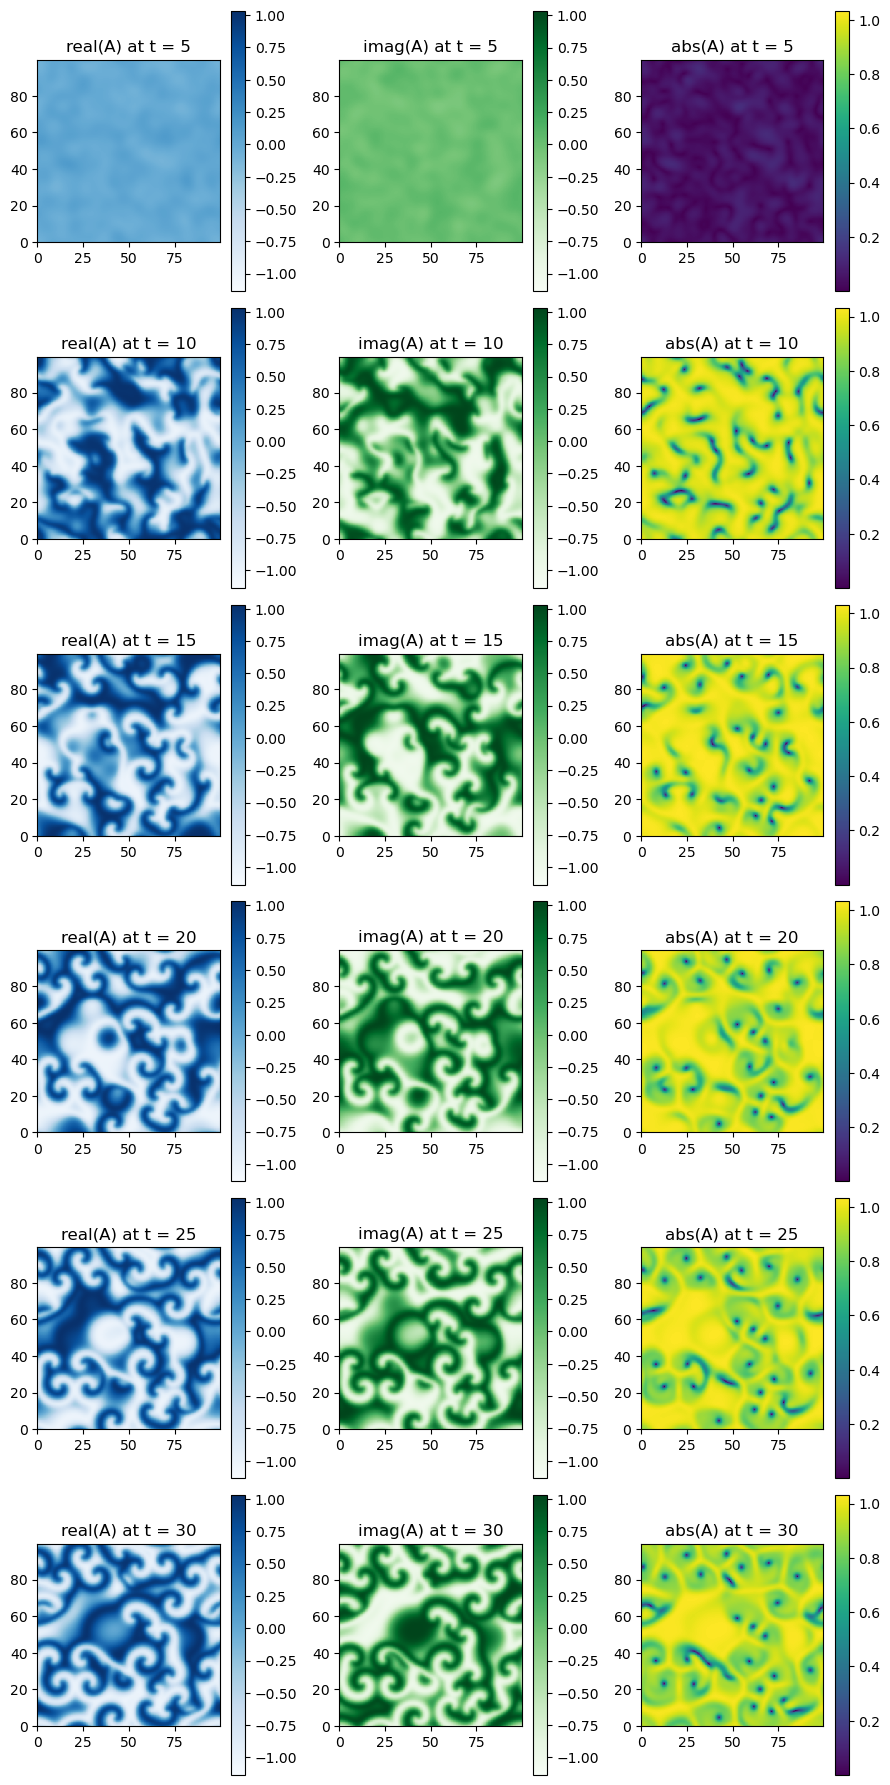

In [36]:
import matplotlib.pyplot as plt

def plot(t, x, y, A_num, times, size_per_box = 6):
   fig, ax = plt.subplots(len(times),3)
   fig.set_figheight(size_per_box*len(times))
   fig.set_figwidth(size_per_box*3)
   rng_real = [np.min(np.real(A_num)), np.max(np.real(A_num))]
   rng_imag = [np.min(np.imag(A_num)), np.max(np.imag(A_num))]
   rng_abs = [np.min(np.abs(A_num)), np.max(np.abs(A_num))]

   for i in range(len(times)):
      u_num = A_num[np.max(np.where(t<=times[i]+0.01))]
      ax[i,0].set_title("real(A) at t = " +str(times[i]))
      ax[i,1].set_title("imag(A) at t = " + str(times[i]))
      ax[i,2].set_title("abs(A) at t = " + str(times[i]))
      im0 = ax[i,0].imshow(np.real(u_num), cmap ='Blues', vmax=rng_real[0], vmin=rng_real[1],
                     extent =[x.min(), x.max(), y.min(), y.max()], 
                        interpolation ='nearest', origin ='lower')
      plt.colorbar(im0)
      im1 = ax[i,1].imshow(np.imag(u_num), cmap ='Greens', vmax=rng_imag[0], vmin=rng_imag[1],
                     extent =[x.min(), x.max(), y.min(), y.max()], 
                        interpolation ='nearest', origin ='lower') 
      plt.colorbar(im1)
      im2 = ax[i,2].imshow(np.abs(u_num), cmap="viridis", vmax=rng_abs[0], vmin=rng_abs[1],
                     extent =[x.min(), x.max(), y.min(), y.max()], 
                        interpolation ='nearest', origin ='lower') 
      fig.tight_layout()
      plt.colorbar(im2)

plot(t, x, y, A_num, [5,10,15,20,25,30], size_per_box=3)

100.0

In [17]:
L = np.arange(5)
np.max(np.where(L<3.5))

3

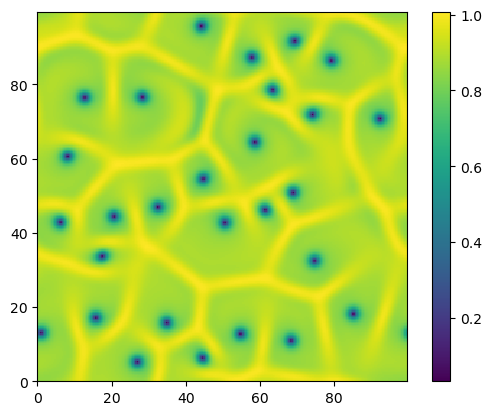

In [39]:
plt.imshow(np.abs(A_num[-1]), interpolation='nearest', extent = [x.min(), x.max(), y.min(), y.max()])
plt.colorbar()